In [1]:
from data import sample_latents
from vis import visualize_latents
from models import InvertibleMLP, ParallelSlots, LinearComposition, CompositionalFunction

In [5]:
D = [2, 4, 3]
M = [16, 16, 16]

z = sample_latents(1000, D, "orthogonal")

phi = ParallelSlots([InvertibleMLP(d_in, d_out, d_hidden=10) for d_in, d_out in zip(D, M)])
C = LinearComposition()
f = CompositionalFunction(C, phi)

In [ ]:
visualize_latents(z, D)

In [38]:
out = f(z[:10], return_slot_outputs=True)

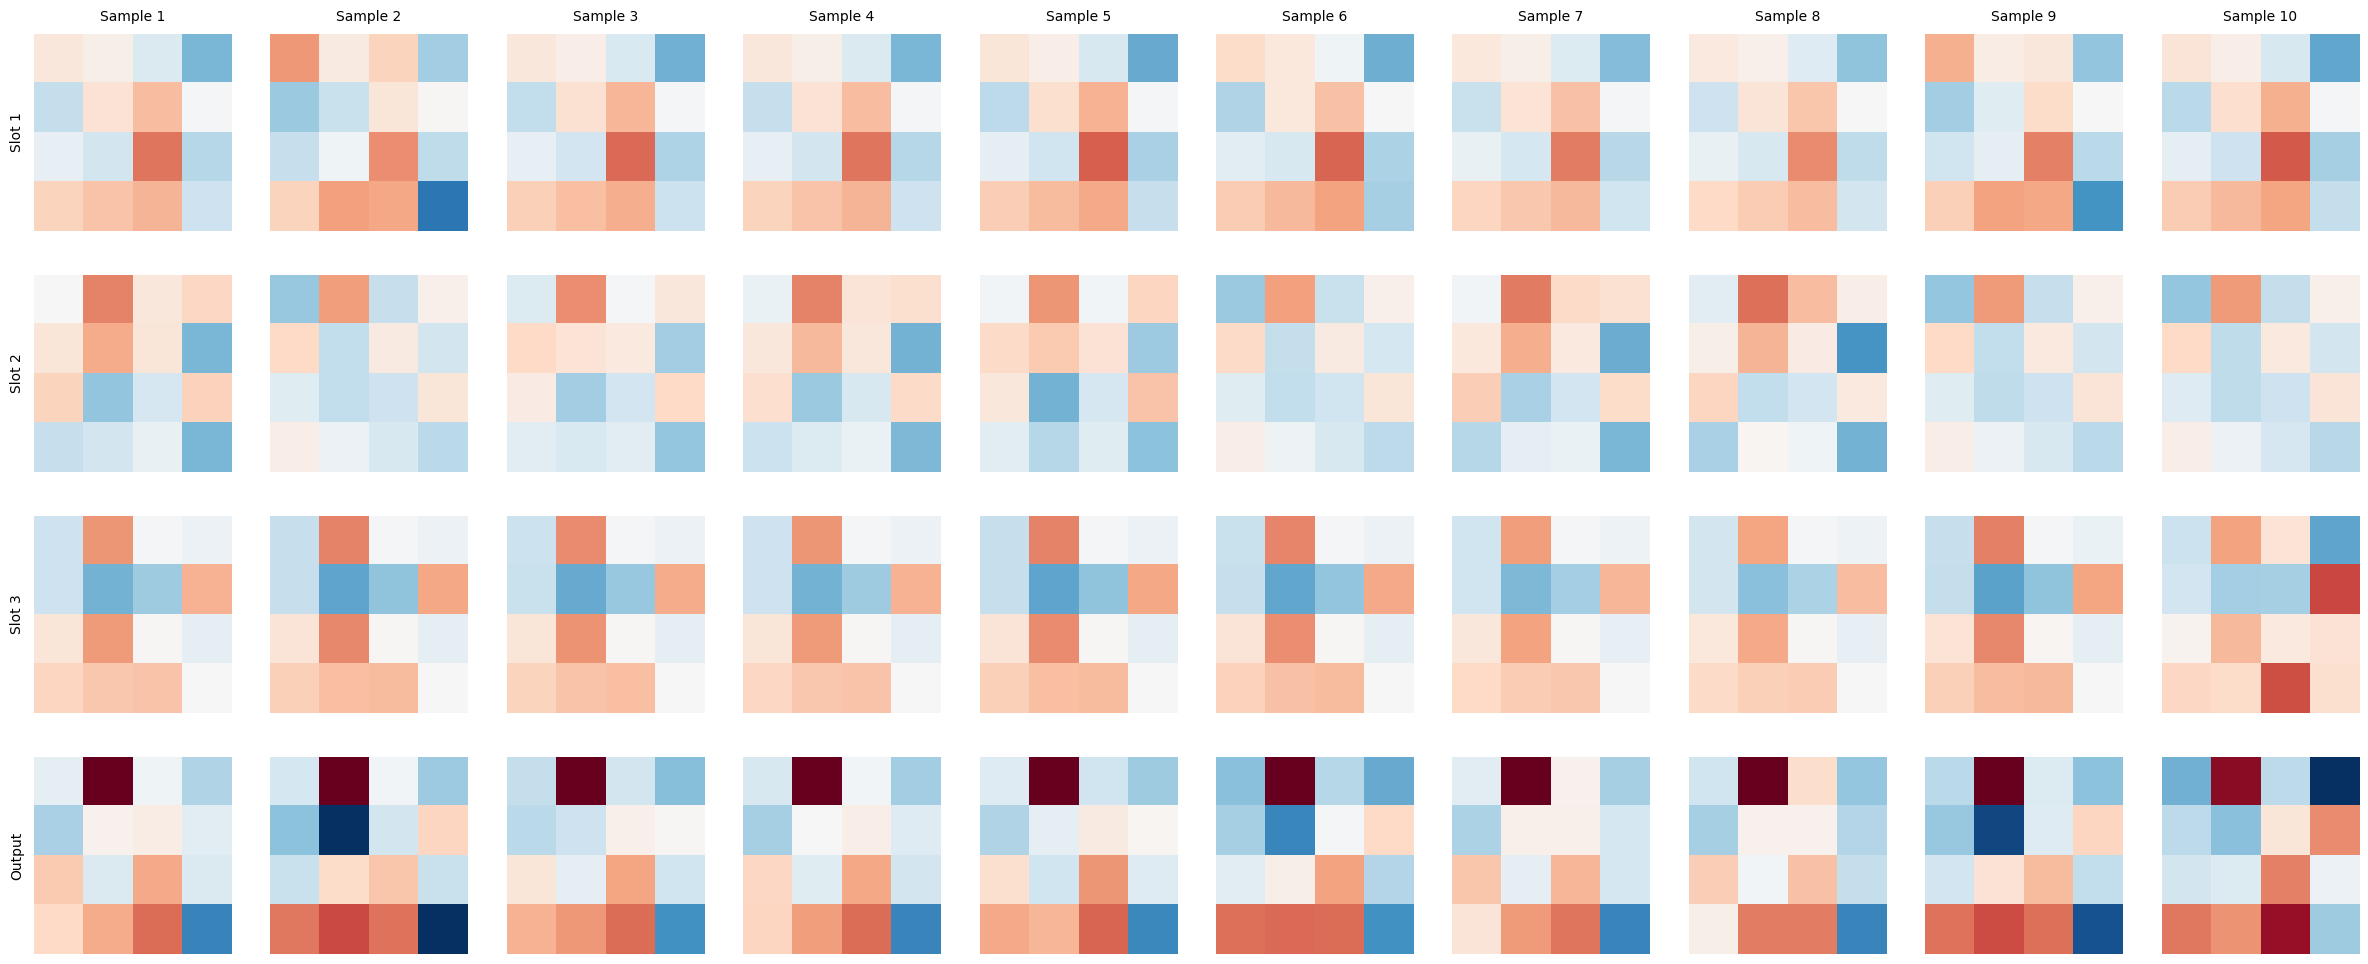

In [41]:
import torch
from typing import Tuple
import matplotlib.pyplot as plt
from math import ceil, sqrt

def rectify(t: torch.Tensor) -> torch.Tensor:
    "Finds the best rectangle representation for a 1d Tensor. Useful for plotting."
    area = t.shape[0]
    max_width = int(ceil(sqrt(area)))
    for w in reversed(range(1, max_width + 1)):
        if area % w == 0:
            return t.view(w, area // w)

def visualize_slots_and_output(output: torch.Tensor, slots: Tuple[torch.Tensor], plot_size: float = 3, title: str = ''):
    output = output.detach()
    slots = [slot.detach() for slot in slots]

    n_cols = output.shape[0]
    n_rows = len(slots) + 1

    fig = plt.figure(figsize=(n_cols * plot_size, n_rows * plot_size))
    fig.suptitle(title)

    for col in range(n_cols):
        # each column uses the same min/max for the colormap
        all_values = torch.cat([slot[col] for slot in slots] + [output[col]])
        vmin = min(all_values.min(), -all_values.max())
        vmax = max(all_values.max(), -all_values.min())

        # plot slots
        for row in range(n_rows - 1):
            ax = fig.add_subplot(n_rows, n_cols, row*n_cols + col + 1)
            ax.imshow(rectify(slots[row][col]), cmap="RdBu", vmin=vmin, vmax=vmax)
            ax.axis("off")

        # plot output
        ax = fig.add_subplot(n_rows, n_cols, (n_rows - 1)*n_cols + col + 1)
        ax.imshow(rectify(output[col]), cmap="RdBu", vmin=vmin, vmax=vmax)
        ax.axis("off")
    
    # add column titles
    for col, ax in enumerate(fig.axes[::n_rows]):
        ax.text(.5, 1.05, f"Sample {col + 1}", horizontalalignment="center",
            verticalalignment="bottom", transform=ax.transAxes)
    
    # add row titles
    for row, ax in enumerate(fig.axes[:n_rows - 1]):
        ax.text(-.05, .5, f"Slot {row + 1}", rotation="vertical", horizontalalignment="right",
            verticalalignment="center", transform=ax.transAxes)

    ax = fig.axes[n_rows - 1]
    ax.text(-.05, .5, "Output", rotation="vertical", horizontalalignment="right",
        verticalalignment="center", transform=ax.transAxes)

    plt.show()

visualize_slots_and_output(*out)